## Introduction to Julia by Dr. Mohammad Masiur Rahaman (masiurr@iitbbs.ac.in)

## Julia is fast

Benchmark the **sum()** and compare against other popular languages.

Consider the **sum** function **sum(a)** which computes   

 $\text{sum}(a) = \Sigma_{i=1}^n a_i$

where $n$ is the length of $a$

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform in [0,1]
sum(a)

5.000398447044802e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

In [4]:
@time sum(a)

  0.009918 seconds (1 allocation: 16 bytes)


4.998923954615387e6

The @time macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a BenchmarkTools.jl package to make benchmarking easy and accurate:

## Use BenchmarkTools for comparison

In [8]:
import Pkg; Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General`
┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Types.jl:997
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [9]:
using BenchmarkTools

### 1. The C language

In [7]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [8]:
c_sum(a)

4.9989239546155315e6

In [9]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbol

true

In [10]:
c_sum(a) - sum(a)

1.4435499906539917e-7

We can now benchmark the C code directly from Julia:

In [11]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 238 samples with 1 evaluation.
 Range (min … max):  20.566 ms …  23.720 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     20.722 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.991 ms ± 489.181 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁██▂                                                         
  ▅████▆▃▃▂▃▃▂▁▃▁▃▃▄▃▄▄▄▃▄▄▄▃▂▄▃▃▁▃▂▃▂▃▂▃▁▁▂▂▁▂▁▃▃▁▁▁▁▁▁▁▁▂▁▁▂ ▃
  20.6 ms         Histogram: frequency by time         22.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 20.566007 msec


In [13]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 20.566

In [14]:
using Plots
gr()

Plots.GRBackend()

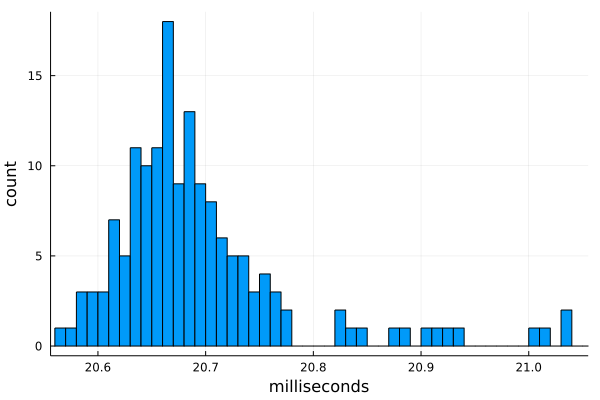

In [15]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

### 2. C with -ffast-math
If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD 
(single instruction, multiple data) instructions.

In [16]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [17]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 441 samples with 1 evaluation.
 Range (min … max):  10.498 ms …  15.497 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.017 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.325 ms ± 769.427 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁▄▁▃█▆▅▂▆ ▁                                                 
  ▂▆███████████▅▄▃▄▂▃▃▂▃▂▄▂▂▃▃▃▃▄▄▃▆▃▃▄▃▃▃▃▄▃▃▃▃▁▃▃▂▂▁▁▂▁▁▂▁▁▃ ▃
  10.5 ms         Histogram: frequency by time         13.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [18]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 2 entries:
  "C"             => 20.566
  "C -ffast-math" => 10.4979

### 3. Python's built in sum

The PyCall package provides a Julia interface to Python:

In [19]:
import Pkg; Pkg.add("PyCall")

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [20]:
using PyCall

In [21]:
# get the Python built-in "sum" function:

pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [22]:
pysum(a) ≈ sum(a)

true

In [23]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.379 s …  1.388 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.386 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.385 s ± 4.281 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                         █                          █ █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█ ▁
  1.38 s        Histogram: frequency by time        1.39 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [24]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 20.566
  "Python built-in" => 1379.0
  "C -ffast-math"   => 10.4979

### 4. Python: numpy
Takes advantage of hardware "SIMD", but only works when it works.

**numpy** is an optimized C library, callable from Python. It may be installed within Julia as follows:

In [25]:
import Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [26]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 611 samples with 1 evaluation.
 Range (min … max):  6.815 ms … 13.308 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.716 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.162 ms ±  1.110 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▂▄█▆▅▂▁                                                 
  ▃▃▃████████▆▄▆▆▄▆▅▅▅▃▃▄▃▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▃▂▂▃▃▃▂▃▁▁▁▁▂▂▂▁▁▁▂ ▃
  6.81 ms        Histogram: frequency by time        12.2 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [27]:
numpy_sum(a)

4.998923954615378e6

In [28]:
numpy_sum(a) ≈ sum(a)

true

In [29]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 20.566
  "Python numpy"    => 6.81485
  "Python built-in" => 1379.0
  "C -ffast-math"   => 10.4979

### 5. Python, hand-written

In [30]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f390c011160>

In [31]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.710 s …    2.008 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.710 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.809 s ± 172.086 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                        ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.71 s         Histogram: frequency by time         2.01 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [32]:
sum_py(a)

4.9989239546155315e6

In [33]:
sum_py(a) ≈ sum(a)

true

In [34]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 20.566
  "Python numpy"        => 6.81485
  "Python hand-written" => 1709.94
  "Python built-in"     => 1379.0
  "C -ffast-math"       => 10.4979

### 6. Julia (built-in)
Written directly in Julia, not in C!

In [35]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [36]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 657 samples with 1 evaluation.
 Range (min … max):  6.172 ms … 14.566 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.219 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.573 ms ±  1.168 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▄▆█▃█▃▄  ▁                                               
  ▄▆█████████▇█▇▇▇▇█▆▇▇▄▄▅▅▅▅▅▅▅▄▄▅▃▃▃▄▃▃▃▄▃▃▃▃▂▂▁▃▃▂▂▂▁▁▁▁▃ ▄
  6.17 ms        Histogram: frequency by time        11.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [37]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 20.566
  "Python numpy"        => 6.81485
  "Python hand-written" => 1709.94
  "Python built-in"     => 1379.0
  "Julia built-in"      => 6.17204
  "C -ffast-math"       => 10.4979

### 7. Julia (hand-written)

In [38]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [39]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 238 samples with 1 evaluation.
 Range (min … max):  20.607 ms …  24.257 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     20.776 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.051 ms ± 528.304 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅█▆▁                                                         
  ██████▄▅▃▃▂▂▃▁▁▂▁▃▂▃▂▄▅▅▅▅▅▂▄▅▄▂▃▃▂▂▁▂▁▂▂▁▁▂▃▃▁▁▁▁▁▂▁▁▁▁▁▁▁▃ ▃
  20.6 ms         Histogram: frequency by time         22.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [40]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 20.566
  "Python numpy"        => 6.81485
  "Julia hand-written"  => 20.6067
  "Python hand-written" => 1709.94
  "Python built-in"     => 1379.0
  "Julia built-in"      => 6.17204
  "C -ffast-math"       => 10.4979

### 8. Julia (hand-written w. simd)

In [41]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [42]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 657 samples with 1 evaluation.
 Range (min … max):  6.169 ms … 15.133 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.178 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.581 ms ±  1.184 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▂██▇▅  ▁                                                
  ▃▃▄█████████▇▇█▆▆█▄▄▄▄▃▃▄▄▄▅▄▄▄▃▄▃▃▂▃▃▃▂▃▂▃▃▁▂▂▂▂▃▁▃▂▁▂▂▁▂ ▄
  6.17 ms        Histogram: frequency by time        11.5 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [43]:
mysum_simd(a)

4.998923954615374e6

In [44]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 6.16899
  "C"                       => 20.566
  "Python numpy"            => 6.81485
  "Julia hand-written"      => 20.6067
  "Python hand-written"     => 1709.94
  "Python built-in"         => 1379.0
  "Julia built-in"          => 6.17204
  "C -ffast-math"           => 10.4979

## Summary

In [45]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....6.2
Julia built-in..............6.2
Python numpy................6.8
C -ffast-math..............10.5
C..........................20.6
Julia hand-written.........20.6
Python built-in..........1379.0
Python hand-written......1709.9


## Performance Tips

#### Benchmarking tips
We saw the package BenchmarkTools and used its @benchmark macro.

Explore the importance of "interpolating" global variables when benchmarking functions.

We interpolate a global variable by throwing a $ in front of it. For example, 

**@benchmark sum($a)**
not

**@benchmark sum(a)**
    
Let's see if this can make a difference by examining the ratio in execution times of sum($a) and sum(a) 
            for differently sized arrays a.

In [46]:
foo1 = rand(10^6)
foo1timeWithDollar = @benchmark sum($foo1)
minimum(foo1timeWithDollar.times)

528407.0

In [47]:
foo1timeNoDollar = @benchmark sum(foo1)
minimum(foo1timeNoDollar.times)

532919.0

In [48]:
foo2 = rand(10^4)
foo2timeWithDollar = @benchmark sum($foo2)
minimum(foo2timeWithDollar.times)

2002.4

In [49]:
foo2timeNoDollar = @benchmark sum(foo2)
minimum(foo2timeNoDollar.times)

2057.777777777778

In [50]:
foo3 = rand(10^2)
foo3timeWithDollar = @benchmark sum($foo3)
minimum(foo3timeWithDollar.times)

19.801204819277107

In [51]:
foo3timeNoDollar = @benchmark sum(foo3)
minimum(foo3timeNoDollar.times)

53.00912778904665

#### Performance tips -- type stability

One way to optimize code in Julia is to ensure **type stability**. 
If the type(s) of some variables in a function are subject to change or ambiguity,
the compiler cannot reason as well about those variables, and performance will take a hit. 

Conversely, we allow the compiler to optimize and generate more efficient machine code when 
we declare variables so that their types will be fixed throughout the function body.

For example, let's say we had functions called baz and bar with the following definitions

In [52]:
function baz()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return 1//3    
    else
        return 0    
    end
end

baz (generic function with 1 method)

In [53]:
function bar()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return .3333333    
    else
        return 0.0    
    end
end

bar (generic function with 1 method)

In [54]:
using BenchmarkTools
bazBenchmark = @benchmark baz()
bazRunTime = minimum(bazBenchmark.times)
dRun = Dict()
dRun["baz run time "] = bazRunTime
barBenchmark = @benchmark bar()
barRunTime = minimum(barBenchmark.times)
dRun["bar run time "] = barRunTime
dRun

Dict{Any, Any} with 2 entries:
  "baz run time " => 38.0977
  "bar run time " => 12.1652

#### Exerice on type stability

In [55]:
function my_sum1(A)
    output = 0
    for x in A
        output += x
    end
    return output
end

my_sum1 (generic function with 1 method)

In [56]:
function my_sum2(A)
    output = 0.0
    for x in A
        output += x
    end
    return output
end

my_sum2 (generic function with 1 method)

In [57]:
A = rand(10^3);

In [58]:
using BenchmarkTools
mysum1Benchmark = @benchmark my_sum1($A)
mysum1RunTime = minimum(mysum1Benchmark.times)

3964.25

In [59]:
sumRun = Dict()
sumRun["sum1 run time "] = mysum1RunTime
mysum2Benchmark = @benchmark my_sum2($A)
mysum2RunTime = minimum(mysum2Benchmark.times)
sumRun["sum2 run time "] = mysum2RunTime
sumRun

Dict{Any, Any} with 2 entries:
  "sum2 run time " => 1935.8
  "sum1 run time " => 3964.25

#### Exercise on type stability

In [60]:
# The type unstable version
function my_sqrt1(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt1 (generic function with 1 method)

In [61]:
# The type stable version, where `output` is always a floating point number.
function my_sqrt2(x)
    output = 1.0
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt2 (generic function with 1 method)

In [62]:
using BenchmarkTools
mysqrt1Benchmark = @benchmark my_sqrt1($1000)
mysqrt1RunTime = minimum(mysqrt1Benchmark.times)

13038.0

In [63]:
mysqrt2Benchmark = @benchmark my_sqrt2($1000)
mysqrt2RunTime = minimum(mysqrt2Benchmark.times)

11038.0

### More Examples

#### Row and Colum major

In [67]:
function row_major(A::Array{Float64})
     m,n = size(A)
     for i in 1:m
        for j in 1:n
           A[i,j] = 1
        end
    end
end

row_major (generic function with 1 method)

In [66]:
function col_major(A::Array{Float64})
     m,n = size(A)
     for j in 1:n
        for i in 1:m
           A[i,j] = 1
        end
    end
end

col_major (generic function with 1 method)

In [68]:
n = 10
A = rand(n,n)

using BenchmarkTools
rowMajBenchmark = @benchmark row_major($A)

BenchmarkTools.Trial: 10000 samples with 944 evaluations.
 Range (min … max):   99.180 ns … 188.390 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      99.819 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   107.517 ns ±  17.908 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                         ▁                   ▁
  ██▇▇▇▇▇▇████████▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▆▆▇▆▇▆▆▆▆██▇▇▇▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆ █
  99.2 ns       Histogram: log(frequency) by time        175 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [69]:
colMajBenchmark = @benchmark col_major($A)

BenchmarkTools.Trial: 10000 samples with 954 evaluations.
 Range (min … max):   91.840 ns … 322.720 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      96.849 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   106.805 ns ±  23.390 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▆█▅▁▁▂▂▂▂▂▂▂▂▁▁▁▁   ▁▁▁▁▂▁▁▁▂▃▂▁▁▁                           ▂
  ████████████████████████████████████▇▆▆▅▅▄▅▁▄▅▅▅▄▅▄▅▅▆▄▄▅▅▅▄▅ █
  91.8 ns       Histogram: log(frequency) by time        207 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

#### Appending vs Preallocation

In [70]:
function my_append()
    v = []
    for i in 1:10000
       push!(v,5)
    end
end

my_append (generic function with 1 method)

In [71]:
function my_prealloc()
    v = Vector{Int64}(undef,10000)
    for i in 1:10000
       v[i] = 5
    end
end

my_prealloc (generic function with 1 method)

In [72]:
@benchmark my_append()

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  112.520 μs …   4.929 ms  ┊ GC (min … max): 0.00% … 86.50%
 Time  (median):     137.804 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   162.092 μs ± 121.157 μs  ┊ GC (mean ± σ):  2.01% ±  2.91%

  ▆█▄▃▃▄▅▃▃▃▄▄▃▂▃▃▃▃▃▃▂▃▃▂▂▃▃▁▁▁▁     ▁                         ▂
  ██████████████████████████████████████▇█▇▆▇▇▇▆▆▇█▇▆▆▆▆▆▅▄▅▄▄▇ █
  113 μs        Histogram: log(frequency) by time        352 μs <

 Memory estimate: 256.64 KiB, allocs estimate: 14.

In [73]:
@benchmark my_prealloc()

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.641 μs …  3.356 ms  ┊ GC (min … max):  0.00% … 97.42%
 Time  (median):     13.123 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   21.647 μs ± 81.873 μs  ┊ GC (mean ± σ):  10.28% ±  2.78%

  ▆█▅▄▃▃▄▅▃▄▃▂▁   ▁                 ▁▁▁                       ▁
  ████████████████████▇▇▆▆▇▇▇██▇▅▆██████▇▆▆▄▅▅▄▄▅▅▅▄▅▆▅▅▅▅▅▅▆ █
  10.6 μs      Histogram: log(frequency) by time      80.7 μs <

 Memory estimate: 78.20 KiB, allocs estimate: 2.

#### Dot operation in a function

In [74]:
f(x) = 3x.^2 + 4x + 7x.^3
fdot(x) = 3 .*x.^2 .+ 4 .*x .+ 7 .*x.^3

fdot (generic function with 1 method)

In [75]:
x = randn(10000)
@benchmark f($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   54.178 μs …   5.565 ms  ┊ GC (min … max):  0.00% … 97.89%
 Time  (median):      84.293 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   121.132 μs ± 212.157 μs  ┊ GC (mean ± σ):  11.46% ±  6.70%

      █▇                                                         
  ▂▂▃███▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  54.2 μs          Histogram: frequency by time          367 μs <

 Memory estimate: 469.22 KiB, allocs estimate: 12.

In [76]:
@benchmark fdot($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   8.391 μs …   5.332 ms  ┊ GC (min … max):  0.00% … 99.61%
 Time  (median):     12.279 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   22.520 μs ± 103.486 μs  ┊ GC (mean ± σ):  11.96% ±  2.77%

    ▄█▅▃▃▂▃▂▁▁▁                       ▁▁▂▂▂▁                   ▁
  ▆█████████████▇▆▇▆▇▅▆▅▅▆▃▃▄▄▂▃▅▂▅▄▅▇████████▇▇▇▇▆▇▇█▇▇▇▇▇▇▆▇ █
  8.39 μs       Histogram: log(frequency) by time      70.8 μs <

 Memory estimate: 78.20 KiB, allocs estimate: 2.

In [77]:
@benchmark f.($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   8.263 μs …  3.644 ms  ┊ GC (min … max):  0.00% … 97.75%
 Time  (median):     12.771 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   19.988 μs ± 78.855 μs  ┊ GC (mean ± σ):  10.66% ±  2.76%

   ▁▅█▆▅▄▄▄▃▃▃▃▂▂▂▁                                           ▁
  ▆███████████████████▇█▆▆▆▆▆▅▄▄▄▅▅▄▆▇▇████▆▆▅▆▆▆▇▆▆▆▆▆▅▆▅▆▅▅ █
  8.26 μs      Histogram: log(frequency) by time      70.9 μs <

 Memory estimate: 78.20 KiB, allocs estimate: 2.